# Hardcode function Tool Calling Agent

In [2]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

c:\Users\virub\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dotenv import load_dotenv

load_dotenv()

True

1. Define a State

In [4]:
class State(TypedDict):
    # Messages have the type "list". The 'add_messags' function
    # in the annotation defines how this state key should b updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [5]:
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm

ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x00000246EF68ECC0>, default_metadata=())

integrate the tools with this LLM

In [6]:
# hard coded values
@tool
def get_stock_price(symbol: str)-> float:
    '''Returns the current price of a stock given the stock symbol
    :param symbol: stock symbol
    '''
    return {
        "MSFT": 200.43,
        "AAPL": 50.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)


# intergrate the hardcoded tool with LLM
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm

ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x00000246EFA6D040>, default_metadata=())

In [7]:
tools = [get_stock_price]

llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x00000246EFA6D040>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_stock_price', 'description': 'Returns the current price of a stock given the stock symbol\n    :param symbol: stock symbol', 'parameters': {'properties': {'symbol': {'type': 'string'}}, 'required': ['symbol'], 'type': 'object'}}}]}, config={}, config_factories=[])

## Now create a chatbot with tools

### Call the tool only required, otherwise don't call it

1. to do this we need to use **tool_condition_edge()**
2. If a person is asking the stock price then only call this call this tool, otherwise don't call it
3. Here tool_conditional_edge start from the *chatbot* and this tools_condition calls either tool or __end__

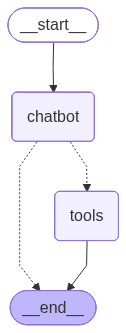

In [8]:
def chatbot(state: State)-> State:
    return {"messages": llm_with_tools.invoke(state['messages'])}


# create a builder
builder = StateGraph(State)
print(builder)

# add nodes
builder.add_node(chatbot)
builder.add_node('tools', ToolNode(tools))

# add edges
builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("chatbot", END)

graph = builder.compile()
graph


In [ ]:
# now try the tool calling
state = graph.invoke({"messages": [{"role": "user", "content": "Who invented the theory of relativity? just give me person name"}]})

In [15]:
state

{'messages': [HumanMessage(content='What is the stock price of accenture right now?', additional_kwargs={}, response_metadata={}, id='265a8bd5-c6b1-46f2-bdac-88e23cacc713'),
  AIMessage(content='What is the stock symbol for accenture?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='lc_run--db330966-0172-424f-bde2-1960805c4c3a-0', usage_metadata={'input_tokens': 39, 'output_tokens': 10, 'total_tokens': 49, 'input_token_details': {'cache_read': 0}})]}

In [16]:
response = state['messages'][-1].content

In [17]:
response

'What is the stock symbol for accenture?'

negative test case

In [19]:
# now try the just LLM call
state = graph.invoke({"messages": [{"role": "user", "content": "Who invented the theory of relativity? just give me person name"}]})
state

{'messages': [HumanMessage(content='Who invented the theory of relativity? just give me person name', additional_kwargs={}, response_metadata={}, id='3573b897-2403-48ce-8800-3bd2cc96ccf0'),
  AIMessage(content='Albert Einstein', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='lc_run--c4a6fa71-bce4-4032-8e81-c37d6c50e633-0', usage_metadata={'input_tokens': 40, 'output_tokens': 3, 'total_tokens': 43, 'input_token_details': {'cache_read': 0}})]}

In [22]:
question = "I wanted to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"
state = graph.invoke({"messages": [{"role": "user", "content":question}]})
response = state['messages'][-1].content

In [24]:
state

{'messages': [HumanMessage(content='I wanted to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?', additional_kwargs={}, response_metadata={}, id='ae5ee5a2-440a-4106-a41b-5ee6f1468ccc'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "MSFT"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='lc_run--9599213d-86b7-4eb8-b3ce-45e0c794adb1-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AMZN'}, 'id': 'cc5a0942-f6f2-4ba0-a59c-bba3f94a679e', 'type': 'tool_call'}, {'name': 'get_stock_price', 'args': {'symbol': 'MSFT'}, 'id': 'fbd5bf0f-4de2-4e04-9639-2f840462050f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 56, 'output_tokens': 16, 'total_tokens': 72, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='150.0', name='get_stock_price', i

In [23]:
print(response)

200.43


----- 2 tool calls but not doing the math -----------